saved
     HPV
0      0
1      0
2      1
3      1
4      1
..   ...
153    1
154    1
155    1
156    1
157    1

[158 rows x 1 columns]
---------------------------------------------
SELEZIONO 33 Features
richiesta:  classification alcohol


C:\Users\marya\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


richiesta:  Classification smoke
richiesta:  50%_PT
richiesta:  20%_PT
richiesta:  60%_PT
richiesta:  media_roi_PT
richiesta:  10%_PT
richiesta:  40%_PT
---------------------------------------------
TAGLIO SULLA CORRELAZIONE
 |corr| > 0.80 --> Tengo 6 Features
---------------------------------------------
OVERSAMPLING SMOTE


TEST
Accuracy model on test: 0.78 
Precision and Sensibility model on test: 0.84
specificità model on test: 1.00
              precision    recall  f1-score   support

           0       0.47      1.00      0.64         8
           1       1.00      0.72      0.84        32

    accuracy                           0.78        40
   macro avg       0.74      0.86      0.74        40
weighted avg       0.89      0.78      0.80        40

0.71875
1.0

TRAIN
Accuracy model on train: 0.79 
Precision and Sensibility model on train: 0.79
specificità model on train: 0.78


C:\Users\marya\AppData\Local\Temp/ipykernel_10868/2983794358.py:205: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_unibest,y_uni)


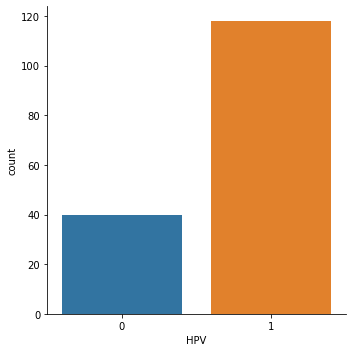

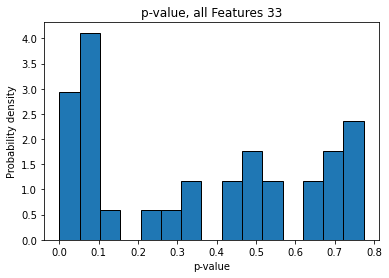

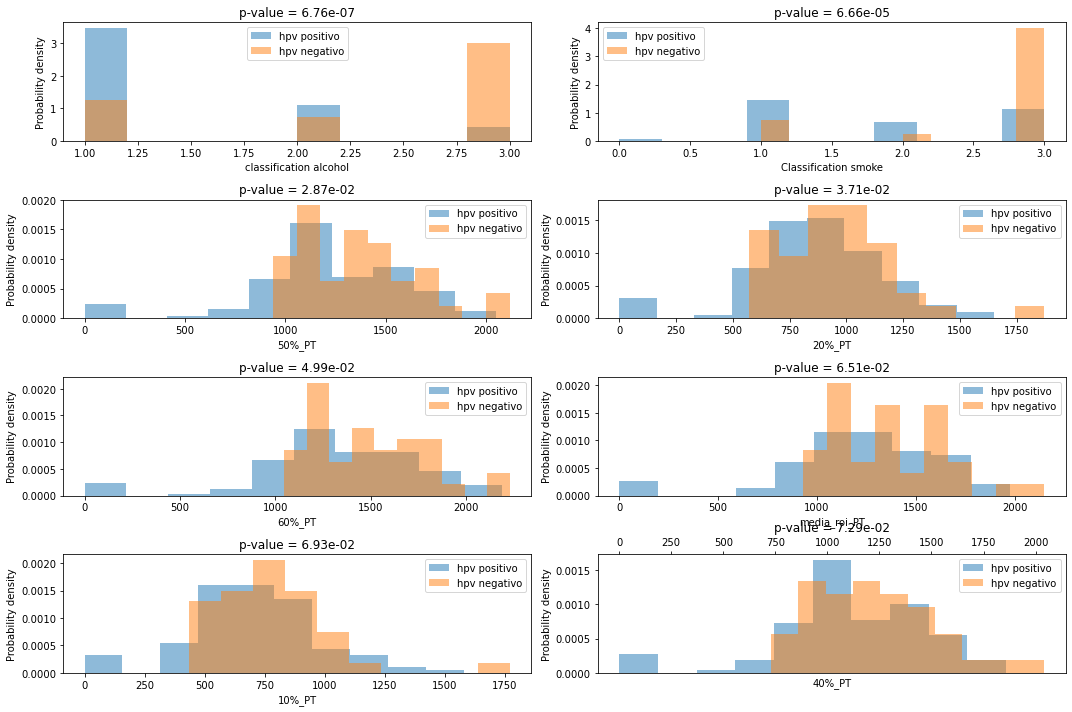

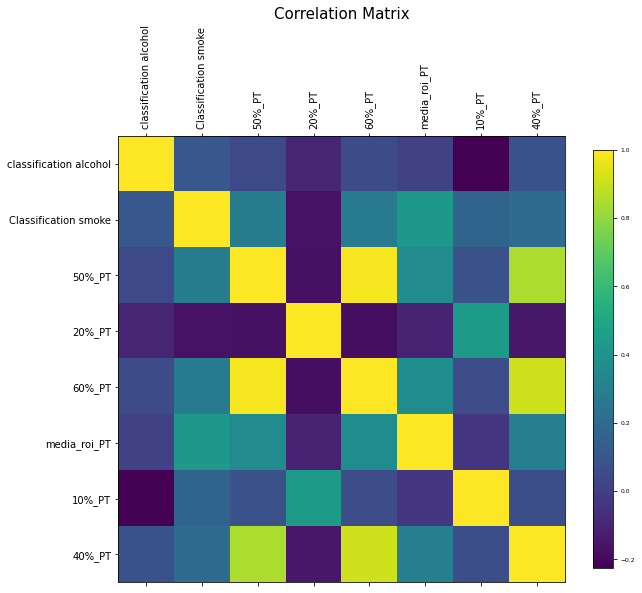

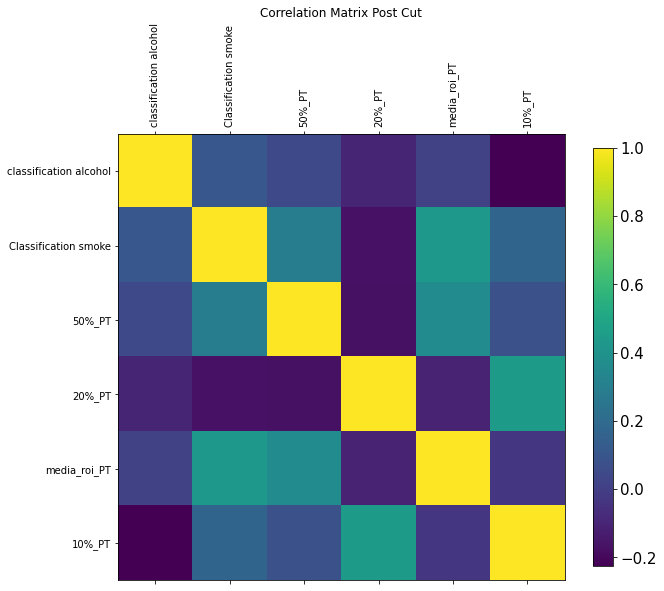

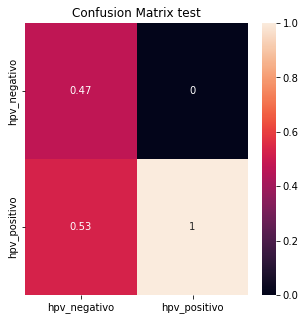

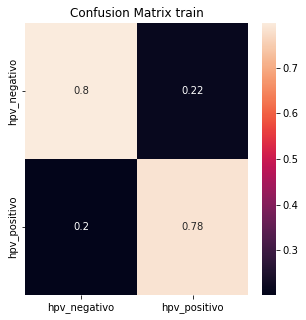

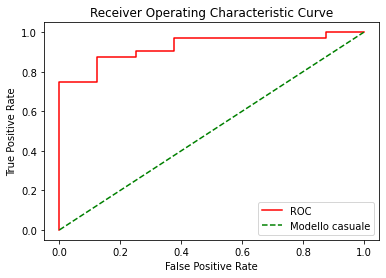

0.92578125


In [5]:
import pandas as pd
import numpy as np
import os
from pandas import ExcelWriter 
from pandas import ExcelFile
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,cross_val_score,RepeatedStratifiedKFold,KFold,RepeatedKFold
from sklearn.feature_selection import SelectKBest,chi2, f_classif,SelectFromModel,SelectPercentile
from sklearn import metrics,linear_model
from sklearn.metrics import classification_report
from imblearn.over_sampling import _random_over_sampler,BorderlineSMOTE,SMOTENC,SMOTE,RandomOverSampler
from collections import Counter
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.metrics import roc_curve
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import recall_score,precision_score
from imblearn.metrics import specificity_score

#lettura tabella hpv e varibili cliniche (sex,ctstage,cnstage)
df_hpv= pd.read_excel('C:\\Users\\marya\\Desktop\\materiali tesi\\file_nifti\\MAPPE2021\\NUOVODATASET.xlsx', index_col =[0])

# replacing values
df_hpv['SEX'].replace(['m', 'f'],
                        [0, 1], inplace=True)
# #hpv
df_hpv['HPV'].replace(['positivo', 'negativo'],
                       [1, 0], inplace=True)

df_hpv['cNstage'].replace(['N0','N1','N2','N2b','N3','N3b'],
                        [0, 1, 2, 3, 4, 5,], inplace=True)

#lettura tabella altre variabili pazienti (media,ln,std e percentili)
df_varibili= pd.read_excel('C:\\Users\\marya\\Desktop\\materiali tesi\\Tabelle valori\\tabella_DATAFRAME.xlsx', index_col=[0])
# print (df_varibili)

dataset = df_varibili.merge(df_hpv, how='left', left_on='paziente', right_on='PAZIENTI')


params = {
    'test_hold':0.25,
    'stratify':False,
    'N_features':33, 
    'corr_cut':0.80, 
    'do_scaler': True,
    'do_corr_cut':True,
    'do_SMOTE': True,
    'shuffle_labels': False,
    'lasso_cut': True
    
    } 
X=dataset.drop(['HPV','paziente','PAZIENTI','coefficente','roi_PT','roi_lymphnodes','cNstage'], axis=1)
features=X.keys()
# print(features)
y=pd.DataFrame(dataset, columns= ['HPV'],) #target 

if params['shuffle_labels']:
    y=np.random.permutation(y)
    
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=params['test_hold'],shuffle=False,stratify=(y if params['stratify']  else None))
#standardizzazione dei valori 
if params['do_scaler']:
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
   
    #Univariate Features Selection

    X_uni = X_train
y_uni=y_train
T = params.get('N_features') #NUMERO DI FEATURES MESSE IN GIOCO
plt.figure(1)

selector = SelectKBest(f_classif, k=T) #selettore con test anova
selector.fit(X_uni, y_uni)
scores = -np.log10(selector.pvalues_)
scores /= scores.max()
sorted_features=np.argsort(selector.pvalues_) #indici p_values ordinati 
# print(selector.pvalues_)
# print(sorted_features)

print(''.join(45*['-']))
print('SELEZIONO {} Features'.format(T))

X_uni=X_uni[:,sorted_features[:T]] 
X_unibest=X_uni[:,sorted_features[:8]] #valori miglior 8 features
X_test=X_test[:,sorted_features[:T]]
X_test2=X_test[:,sorted_features[:8]] #valori miglior 8 features
names = features[sorted_features[:T]] #nome features 
names2=features[sorted_features[:8]] #nome migliori 8 features 


 # istogramma all Features
f,ax=plt.subplots(1)
ax.hist(selector.pvalues_[sorted_features[:T]],15,density=True, edgecolor='black')
ax.set_title('p-value, all Features {}'.format(T))
ax.set_xlabel('p-value')
ax.set_ylabel('Probability density')


# histogram best 8 features 
f,axex=plt.subplots(4,2,figsize=(15,10))
for i, ax in enumerate(axex.flat):
    sel = sorted_features[i]
#     print(sel)
    col = features[sel]
#     print(col)
    print('richiesta: ',col)
    
    ax.hist(X[y['HPV']==1][[col]],density=True,histtype='bar',alpha=0.5, label='hpv positivo')
    ax.hist(X[y['HPV']==0][[col]],density=True,histtype='bar',alpha=0.5, label='hpv negativo')
    ax.set_title("p-value = {:.2e}".format(selector.pvalues_[sel],3))
    ax.set_xlabel(features[sel])
    ax.set_ylabel('Probability density')
    ax.legend() 
    f.tight_layout()
        
#----------------- matrice di correlazione 8 best features

correlation_p=np.corrcoef(X_unibest,rowvar=False) #calcolo correlazione 
# print(correlation_p)
f = plt.figure(figsize=(10,10))
plt.matshow(correlation_p, fignum=f.number)
plt.xticks(range(len(names2)),names2, fontsize=10, rotation=90)
plt.yticks(range(len(names2)),names2, fontsize=10)
cb = plt.colorbar(shrink=0.75)
cb.ax.tick_params(labelsize=6)
ax.xaxis.set_ticks_position('top')
plt.title('Correlation Matrix', fontsize=15);


X_tmp = X_unibest 

# taglio sulla correlazione e replot
columns = np.full((correlation_p.shape[0],), True, dtype=bool)
for i in range(correlation_p.shape[0]):
    for j in range(i+1, correlation_p.shape[0]):
        if np.abs(correlation_p[i,j]) >= params['corr_cut']: #taglio anche le corr negative 
            if columns[j]:
                columns[j] = False
                
X_tmp = X_tmp[:,columns] 

X_tmp1 = np.delete(X_tmp, [5], axis=1) 
# print(X_tmp1.shape)
names2 = names2[columns]

correlation_p2=np.corrcoef(X_tmp,rowvar=False) #calcolo correlazione post taglio
# print(correlation_p)
f = plt.figure(figsize=(10, 10))
plt.matshow(correlation_p2, fignum=f.number)
plt.xticks(range(len(names2)),names2, fontsize=10, rotation=90)
plt.yticks(range(len(names2)),names2, fontsize=10)
ax.xaxis.set_ticks_position('top')
cb = plt.colorbar(shrink=0.75)
cb.ax.tick_params(labelsize=15)
plt.title('Correlation Matrix Post Cut', fontsize=12)

if params['do_corr_cut']:
    print(''.join(45*['-']))
    print('TAGLIO SULLA CORRELAZIONE\n |corr| > {:.2f} --> Tengo {} Features'.format(params['corr_cut'],np.sum(columns)))

X_unibest = X_tmp1
X_test2 = X_test2[:,columns]
# print(X_test2)
X_test3= np.delete(X_test2, [5], axis=1) #delle 7 migliori features scelgo le prime 5 per realizzare il calssificatore
# print(X_test3.shape)

#SMOTE tecnica di sovracampionamento.
if params['do_SMOTE']:
    print(''.join(45*['-']))
    print('OVERSAMPLING SMOTE\n')
    oversample = SMOTE(random_state=0)
    X_unibest, y_uni = oversample.fit_resample(X_unibest, y_uni)

#creazione Random forest 
model=RandomForestClassifier(n_estimators=50, random_state=0,max_depth=2)
model.fit(X_unibest,y_uni)
y_pred_test=model.predict(X_test3)
print('\nTEST')
print('Accuracy model on test: %.2f ' % (metrics.accuracy_score(y_test, y_pred_test,normalize=True)))
print('Precision and Sensibility model on test: %.2f' % (metrics.f1_score(y_test, y_pred_test)))
print('specificità model on test: %.2f' % specificity_score(y_test, y_pred_test))

y_pred_train=model.predict(X_unibest)
print('\nTRAIN')
print('Accuracy model on train: %.2f ' % (metrics.accuracy_score(y_uni, y_pred_train)))
print('Precision and Sensibility model on train: %.2f' % (metrics.f1_score(y_uni, y_pred_train)))
print('specificità model on train: %.2f' % specificity_score(y_uni, y_pred_train))
#matrice di confusione per il test 
cm_test = confusion_matrix(y_test,y_pred_test, normalize='pred')
f = plt.figure(figsize=(5, 5))
df_cm =pd.DataFrame(cm_test,columns=['hpv_negativo','hpv_positivo'],index=['hpv_negativo','hpv_positivo'])
sns.heatmap(df_cm, annot=True)
plt.title('Confusion Matrix test')
plt.show()
#matrice di confusione per il train
cm_train = confusion_matrix(y_uni,y_pred_train, normalize='pred')
f = plt.figure(figsize=(5, 5))
df_cm =pd.DataFrame(cm_train,columns=['hpv_negativo','hpv_positivo'],index=['hpv_negativo','hpv_positivo'])
sns.heatmap(df_cm, annot=True)
plt.title('Confusion Matrix train')
plt.show()
#creazione curva ROC
def plot_roc_curve(fper, tper):
    plt.plot(fper, tper, color='red', label='ROC')
    plt.plot([0, 1], [0, 1], color='green', linestyle='--', label="Modello casuale")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend()
    plt.show()
prob = model.predict_proba(X_test3)
preds = prob[:, 1]
fper, tper, thresholds = metrics.roc_curve(y_test, preds)
plot_roc_curve(fper, tper)
AUC= metrics.roc_auc_score(y_test, preds)
print(AUC)



---------------------------------------------
OVERSAMPLING SMOTE

K= 0 |Precision and Sensibility model on test-  0.85   | Accuracy model on test -  0.86 |Specificità model on test-  0.89   |
K= 1 |Precision and Sensibility model on test-  0.63   | Accuracy model on test -  0.60 |Specificità model on test-  0.53   |
K= 2 |Precision and Sensibility model on test-  0.91   | Accuracy model on test -  0.91 |Specificità model on test-  0.94   |


C:\Users\marya\AppData\Local\Temp/ipykernel_10868/1457216740.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_cross.fit(X_unibest[train,:],y_uni.loc[train])
C:\Users\marya\AppData\Local\Temp/ipykernel_10868/1457216740.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_cross.fit(X_unibest[train,:],y_uni.loc[train])
C:\Users\marya\AppData\Local\Temp/ipykernel_10868/1457216740.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_cross.fit(X_unibest[train,:],y_uni.loc[train])
C:\Users\marya\AppData\Local\Temp/ipykernel_10868/1457216740.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change th

K= 3 |Precision and Sensibility model on test-  0.82   | Accuracy model on test -  0.82 |Specificità model on test-  0.82   |
K= 4 |Precision and Sensibility model on test-  0.72   | Accuracy model on test -  0.71 |Specificità model on test-  0.65   |
Mean Accuracy: 0.78 +/- 0.11 |  Mean Precision and Sensibility: 0.79 +/- 0.10 |  Mean Specificità: 0.77 +/- 0.15


C:\Users\marya\AppData\Local\Temp/ipykernel_10868/1457216740.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_cross.fit(X_unibest[train,:],y_uni.loc[train])


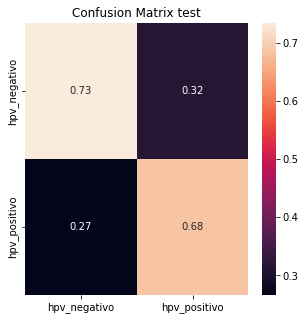

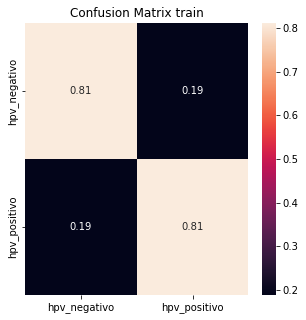

C:\Users\marya\AppData\Local\Temp/ipykernel_10868/1457216740.py:68: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  probas_ = model_cross.fit(X_unibest[train,:],y_uni.loc[train]).predict_proba(X_unibest[test,:])
C:\Users\marya\AppData\Local\Temp/ipykernel_10868/1457216740.py:68: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  probas_ = model_cross.fit(X_unibest[train,:],y_uni.loc[train]).predict_proba(X_unibest[test,:])
C:\Users\marya\AppData\Local\Temp/ipykernel_10868/1457216740.py:68: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  probas_ = model_cross.fit(X_unibest[train,:],y_uni.loc[train]).predict_proba(X_unibest[test,:])
C:\Users\marya\AppData\Local\Temp/ipy

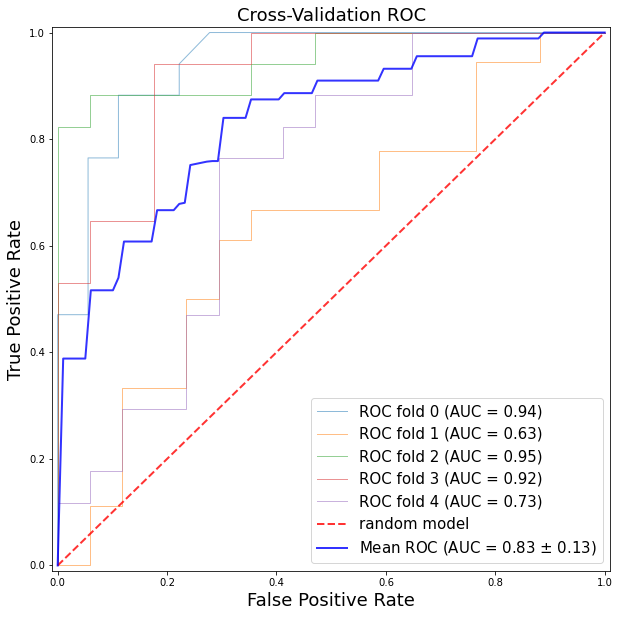

hhhh


In [2]:
#CROSS VALIDATION 

from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5,shuffle=False)
acc=np.zeros([5])
f1_score=np.zeros([5])
specificità=np.zeros([5])

if params['do_SMOTE']:
    print(''.join(45*['-']))
    print('OVERSAMPLING SMOTE\n')
    oversample = SMOTE(random_state=0)
    X_unibest, y_uni = oversample.fit_resample(X_unibest, y_uni)

    
for i, [train, test] in enumerate(skf.split(X_unibest, y_uni)):
        model_cross=RandomForestClassifier(n_estimators=50, random_state=0,max_depth=2)
        model_cross.fit(X_unibest[train,:],y_uni.loc[train])
        acc[i]=metrics.accuracy_score(y_uni.loc[test],model_cross.predict(X_unibest[test,:]))
        f1_score[i]=metrics.f1_score(y_uni.loc[test], model_cross.predict(X_unibest[test,:]))
        specificità[i]=specificity_score(y_uni.loc[test], model_cross.predict(X_unibest[test,:]))
        print('K= {} |Precision and Sensibility model on test-  {:.2f}   | Accuracy model on test -  {:.2f} |Specificità model on test-  {:.2f}   |'.format(
            i,f1_score[i],acc[i],specificità[i]))
    

print('Mean Accuracy: {:.2f} +/- {:.2f} |  Mean Precision and Sensibility: {:.2f} +/- {:.2f} |  Mean Specificità: {:.2f} +/- {:.2f}'.format(
            acc.mean(),acc.std(), f1_score.mean(),f1_score.std(),specificità.mean(), specificità.std()))

y_pred_test=model_cross.predict(X_unibest[test,:])
y_pred_train=model_cross.predict(X_unibest[train,:])

# matrice di confusione 
cm_test = confusion_matrix(y_uni.loc[test],y_pred_test, normalize='pred')
f = plt.figure(figsize=(5, 5))
df_cm =pd.DataFrame(cm_test,columns=['hpv_negativo','hpv_positivo'],index=['hpv_negativo','hpv_positivo'])
sns.heatmap(df_cm, annot=True)
plt.title('Confusion Matrix test')
plt.show()

cm_train = confusion_matrix(y_uni.loc[train],y_pred_train, normalize='pred')
f = plt.figure(figsize=(5, 5))
df_cm =pd.DataFrame(cm_train,columns=['hpv_negativo','hpv_positivo'],index=['hpv_negativo','hpv_positivo'])
sns.heatmap(df_cm, annot=True)
plt.title('Confusion Matrix train')
plt.show()

# Compute ROC curve and area the curve        
tprs_cross = []
aucs = []
mean_fpr_cross = np.linspace(0, 1, 100)
plt.figure(figsize=(10,10))
i = 0
for i, [train, test] in enumerate(skf.split(X_unibest, y_uni)):
    probas_ = model_cross.fit(X_unibest[train,:],y_uni.loc[train]).predict_proba(X_unibest[test,:])
    
   
    fpr_cross, tpr_cross, thresholds = metrics.roc_curve(y_uni.loc[test], probas_[:, 1])
    tprs_cross.append(np.interp(mean_fpr_cross, fpr_cross, tpr_cross))
    tprs_cross[-1][0] = 0.0
    roc_auc = metrics.auc(fpr_cross, tpr_cross)
    aucs.append(roc_auc)
    plt.plot(fpr_cross, tpr_cross, lw=1, alpha=0.5,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='random model', alpha=.8)

mean_tpr_cross = np.mean(tprs_cross, axis=0)
mean_tpr_cross[-1] = 1.0
mean_auc = metrics.auc(mean_fpr_cross, mean_tpr_cross)
std_auc = np.std(aucs)
plt.plot(mean_fpr_cross, mean_tpr_cross, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate',fontsize=18)
plt.ylabel('True Positive Rate',fontsize=18)
plt.title('Cross-Validation ROC',fontsize=18)
plt.legend(loc="lower right", prop={'size': 15})
plt.show()


